## IMPORT, CONFIG

In [1]:
import numpy as np
import tensorflow as tf
import tqdm, os
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as displayer
import math
from tensorflow.examples.tutorials.mnist import input_data
import struct

class Config(object):
    pass
config = Config()
config.batch_size = 128
config.learning_rate = 0.02
config.use_float16 = False
config.BN_epsilon = 1e-5
config.BN_decay = 0.995
config.data_path = '../../datasets/MNIST/'
#mnist = input_data.read_data_sets('../../datasets/MNIST', one_hot=False)

In [2]:
def read_MNIST(dataset = "training", path = "."):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """
    print (dataset)
    if dataset is "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols, 1) / 255

    return img, lbl

class Dataset():
    def __init__(self):
        self.batch_size = config.batch_size
        self.x_train, self.y_train = read_MNIST(dataset='training', path=config.data_path)
        self.x_test, self.y_test = read_MNIST(dataset='testing', path=config.data_path)
        self.start_batch_index = self.end_batch_index = self.num_train_images = np.shape(self.y_train)[0]
        
    def get_next_batch(self):
        if self.start_batch_index == self.num_train_images:
            #suffle
            self.suffle()
            self.start_batch_index = 0
            self.end_batch_index = self.batch_size
            
        if self.end_batch_index > self.num_train_images:
            #suffle
            self.end_batch_index = self.num_train_images
            self.start_batch_index = self.num_train_images - self.batch_size
        
        batch_x = self.x_train[self.start_batch_index : self.end_batch_index].astype(
            np.float16 if config.use_float16 else np.float32)
        batch_y = self.y_train[self.start_batch_index : self.end_batch_index]
        self.start_batch_index = self.end_batch_index
        self.end_batch_index += self.batch_size
        
        return (batch_x, batch_y)
    
    def suffle(self):
        perm = np.random.permutation(self.num_train_images)
        self.x_train = self.x_train[perm]
        self.y_train = self.y_train[perm]
        
dataset = Dataset()
print (np.shape(dataset.x_test))

training
testing
(10000, 28, 28, 1)


## BUILD GRAPHS

In [3]:
def batch_norm_wrapper(x, is_training, step):
    """
    is_training: a boolean tensor
    """
    with tf.variable_scope('batch_norm') as scope:
        gamma = tf.Variable(tf.ones([x.get_shape()[-1]]), trainable = True)
        beta  = tf.Variable(tf.zeros([x.get_shape()[-1]]), trainable = True)
        pop_mean = tf.Variable(tf.zeros([x.get_shape()[-1]]), trainable=False, name = "pop_mean")
        pop_var  = tf.Variable(tf.constant(1.0, shape = [x.get_shape()[-1]]), trainable=False, name = "pop_var")

    def using_batch_statistics():
        batch_mean, batch_var = tf.nn.moments(x,[0])
        train_mean = tf.assign(pop_mean,
                               pop_mean * config.BN_decay + batch_mean * (1 - config.BN_decay))
        train_var = tf.assign(pop_var,
                              pop_var * config.BN_decay + batch_var * (1 - config.BN_decay))
#         mean = tf.clip_by_value(batch_mean, pop_mean / 3, pop_mean * 3)
#         var = tf.clip_by_value(batch_var, pop_var - 2, pop_var + 2)
        with tf.control_dependencies([train_mean, train_var]):
#             return tf.cond(tf.greater(step, 5000), lambda: tf.nn.batch_normalization(x, mean, var, beta, gamma, config.BN_epsilon),
#                                                 lambda: tf.nn.batch_normalization(x, batch_mean, batch_var, beta, gamma, config.BN_epsilon))
            return tf.nn.batch_normalization(x,
                batch_mean, batch_var, beta, gamma, config.BN_epsilon)
    def using_global_statistics():
        return tf.nn.batch_normalization(x,
            pop_mean, pop_var, beta, gamma, config.BN_epsilon)
    
    return tf.cond(is_training, 
                   using_batch_statistics, 
                   using_global_statistics)


def batch_norm_wrapper_cnn(x, n_out, is_training, step):
    with tf.variable_scope('batch_norm'):
        xs = x.get_shape()
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                    name = 'beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                     name = 'gamma', trainable=True)
        pop_mean = tf.Variable(tf.zeros([n_out]), trainable=False, name = "pop_mean")
        pop_var  = tf.Variable(tf.constant(1.0, shape = [n_out]), trainable=False, name = "pop_var")
        
    def using_batch_statistics():
        batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2])
        train_mean = tf.assign(pop_mean,
                               pop_mean * config.BN_decay + batch_mean * (1 - config.BN_decay))
        train_var  = tf.assign(pop_var,
                               pop_var * config.BN_decay + batch_var * (1 - config.BN_decay))
#         mean = tf.clip_by_value(batch_mean, pop_mean / 3, pop_mean * 3)
#         var = tf.clip_by_value(batch_var, pop_var - 2, pop_var + 2)
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(x, batch_mean, batch_var, beta, gamma, config.BN_epsilon)
#             return tf.cond(tf.greater(step, 5000), lambda: tf.nn.batch_normalization(x, mean, var, beta, gamma, config.BN_epsilon),
#                                                 lambda: tf.nn.batch_normalization(x, batch_mean, batch_var, beta, gamma, config.BN_epsilon))
        
    def using_global_statistics():
        return tf.nn.batch_normalization(x,
            pop_mean, pop_var, beta, gamma, config.BN_epsilon)
    
    return tf.cond(is_training, 
                   using_batch_statistics, 
                   using_global_statistics)

def variable_on_cpu(name, shape, initializer):
    with tf.device('/gpu:0'):
        dtype = tf.float16 if config.use_float16 else tf.float32
        var = tf.get_variable(name, shape, initializer=initializer, dtype=dtype)
    return var

def variable_with_weight_decay(name, shape, stddev, wd):
    dtype = tf.float16 if config.use_float16 else tf.float32
    var = variable_on_cpu(
        name,
        shape,
        tf.truncated_normal_initializer(stddev=stddev, dtype=dtype))
    if wd is not None:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    return var

In [4]:
def build_graph(is_using_BN = True, is_using_dropout = False):
    """define place holder"""
    dtype = tf.float16 if config.use_float16 else tf.float32
    x = tf.placeholder(dtype, shape=[None, 28, 28, 1])
    y = tf.placeholder(tf.int32)
    is_training = tf.placeholder(tf.bool)
    weight_decay = 0.001
    global_step = tf.Variable(0, trainable=False)
    #xx = tf.image.resize_images(x, [32, 32])
    
    """1st convolution layer with max pooling"""
    with tf.variable_scope('conv1_1') as scope:
        kernel = variable_with_weight_decay('weights', 
                                             shape = [3, 3, 1, 32], 
                                             stddev = np.sqrt(1 / (3 * 3 * 1)), 
                                             wd = weight_decay)
        conv1_1 = tf.nn.conv2d(x, kernel, [1, 1, 1, 1], padding='SAME')
        if is_using_BN:
            conv1_1 = batch_norm_wrapper_cnn(conv1_1, 32, is_training, step = global_step)
        else:
            biases = variable_on_cpu('biases', 32, tf.constant_initializer(0.01))
            conv1_1 = tf.add(conv1_1, biases)
        conv1_1 = tf.nn.relu(conv1_1)
        
    with tf.variable_scope('conv1_2') as scope:
        kernel = variable_with_weight_decay('weights', 
                                             shape = [3, 3, 32, 32], 
                                             stddev = np.sqrt(2 / (3 * 3 * 32)), 
                                             wd = weight_decay)
        conv1_2 = tf.nn.conv2d(conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
        if is_using_BN:
            conv1_2 = batch_norm_wrapper_cnn(conv1_2, 32, is_training, step = global_step)
        else:
            biases = variable_on_cpu('biases', 32, tf.constant_initializer(0.01))
            conv1_2 = tf.add(conv1_2, biases)
        conv1_2 = tf.nn.relu(conv1_2)
    
    
    """2nd convolution layer with max pooling"""
    with tf.variable_scope('conv1_3') as scope:
        kernel = variable_with_weight_decay('weights', 
                                             shape = [3, 3, 32, 32], 
                                             stddev = np.sqrt(2 / (3 * 3 * 3)), 
                                             wd = weight_decay)
        conv1_3 = tf.nn.conv2d(conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
        if is_using_BN:
            conv1_3 = batch_norm_wrapper_cnn(conv1_3, 32, is_training, step = global_step)
        else:
            biases = variable_on_cpu('biases', 32, tf.constant_initializer(0.01))
            conv1_3 = tf.add(conv1_3, biases)
        conv1_3 = tf.nn.relu(conv1_3)
    
    
    """3rd convolution layer with max pooling"""
    with tf.variable_scope('conv1_4') as scope:
        kernel = variable_with_weight_decay('weights',
                                             shape = [3, 3, 32, 32],
                                             stddev = np.sqrt(2 / (3 * 3 * 32)),
                                             wd = weight_decay)
        
        conv1_4 = tf.nn.conv2d(conv1_2, kernel, [1, 1, 1, 1], padding='SAME')
        if is_using_BN:
            conv1_4 = batch_norm_wrapper_cnn(conv1_4, 32, is_training, step = global_step)
        else:
            biases = variable_on_cpu('biases', 32, tf.constant_initializer(0.01))
            conv1_4 = tf.add(conv1_4, biases)
        conv1_4 = tf.nn.relu(conv1_4)
        pool1 = tf.nn.max_pool(conv1_4, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                         padding = 'SAME', name = 'pool2')
#         if is_using_BN:
#             pool1 = batch_norm_wrapper_cnn(pool1, 32, is_training)
        
    
    """1st convolution layer with max pooling"""
    with tf.variable_scope('conv2_1') as scope:
        kernel = variable_with_weight_decay('weights', 
                                             shape = [3, 3, 32, 64], 
                                             stddev = np.sqrt(1 / (3 * 3 * 64)), 
                                             wd = weight_decay)
        conv2_1 = tf.nn.conv2d(pool1, kernel, [1, 1, 1, 1], padding='SAME')
        if is_using_BN:
            conv2_1 = batch_norm_wrapper_cnn(conv2_1, 64, is_training, step = global_step)
        else:
            biases = variable_on_cpu('biases', 64, tf.constant_initializer(0.01))
            conv2_1 = tf.add(conv2_1, biases)
        conv2_1 = tf.nn.relu(conv2_1)
    
    
    """2nd convolution layer with max pooling"""
    with tf.variable_scope('conv2_2') as scope:
        kernel = variable_with_weight_decay('weights', 
                                             shape = [3, 3, 64, 64], 
                                             stddev = np.sqrt(2 / (3 * 3 * 64)), 
                                             wd = weight_decay)
        conv2_2 = tf.nn.conv2d(conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
        if is_using_BN:
            conv2_2 = batch_norm_wrapper_cnn(conv2_2, 64, is_training, step = global_step)
        else:
            biases = variable_on_cpu('biases', 64, tf.constant_initializer(0.01))
            conv2_2 = tf.add(conv2_2, biases)
        conv2_2 = tf.nn.relu(conv2_2)
        
    with tf.variable_scope('conv2_3') as scope:
        kernel = variable_with_weight_decay('weights', 
                                             shape = [3, 3, 64, 64], 
                                             stddev = np.sqrt(2 / (3 * 3 * 64)), 
                                             wd = weight_decay)
        conv2_3 = tf.nn.conv2d(conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
        if is_using_BN:
            conv2_3 = batch_norm_wrapper_cnn(conv2_3, 64, is_training, step = global_step)
        else:
            biases = variable_on_cpu('biases', 64, tf.constant_initializer(0.01))
            conv2_3 = tf.add(conv2_3, biases)
        conv2_3 = tf.nn.relu(conv2_3)
    
    
    """3rd convolution layer with max pooling"""
    with tf.variable_scope('conv2_4') as scope:
        kernel = variable_with_weight_decay('weights',
                                             shape = [3, 3, 64, 64],
                                             stddev = np.sqrt(2 / (3 * 3 * 64)),
                                             wd = weight_decay)
        
        conv2_4 = tf.nn.conv2d(conv2_2, kernel, [1, 1, 1, 1], padding='SAME')
        if is_using_BN:
            conv2_4 = batch_norm_wrapper_cnn(conv2_4, 64, is_training, step = global_step)
        else:
            biases = variable_on_cpu('biases', 64, tf.constant_initializer(0.01))
            conv2_4 = tf.add(conv2_4, biases)
        conv2_4 = tf.nn.relu(conv2_4)
        
        pool2 = tf.nn.max_pool(conv2_4, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                         padding = 'SAME', name = 'pool2')
#         if is_using_BN:
#             pool2 = batch_norm_wrapper_cnn(pool2, 64, is_training)
        
    
    with tf.variable_scope('conv3_1') as scope:
        kernel = variable_with_weight_decay('weights', 
                                             shape = [3, 3, 64, 128], 
                                             stddev = np.sqrt(1 / (3 * 3 * 64)), 
                                             wd = weight_decay)
        conv3_1 = tf.nn.conv2d(pool2, kernel, [1, 1, 1, 1], padding='SAME')
        if is_using_BN:
            conv3_1 = batch_norm_wrapper_cnn(conv3_1, 128, is_training, step = global_step)
        else:
            biases = variable_on_cpu('biases', 128, tf.constant_initializer(0.01))
            conv3_1 = tf.add(conv3_1, biases)
        conv3_1 = tf.nn.relu(conv3_1)
    
    
    """2nd convolution layer with max pooling"""
    with tf.variable_scope('conv3_2') as scope:
        kernel = variable_with_weight_decay('weights', 
                                             shape = [3, 3, 128, 128], 
                                             stddev = np.sqrt(2 / (3 * 3 * 128)), 
                                             wd = weight_decay)
        conv3_2 = tf.nn.conv2d(conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
        if is_using_BN:
            conv3_2 = batch_norm_wrapper_cnn(conv3_2, 128, is_training, step = global_step)
        else:
            biases = variable_on_cpu('biases', 128, tf.constant_initializer(0.01))
            conv3_2 = tf.add(conv3_2, biases)
        conv3_2 = tf.nn.relu(conv3_2)
        
        
    with tf.variable_scope('conv3_3') as scope:
        kernel = variable_with_weight_decay('weights', 
                                             shape = [3, 3, 128, 128], 
                                             stddev = np.sqrt(2 / (3 * 3 * 128)), 
                                             wd = weight_decay)
        conv3_3 = tf.nn.conv2d(conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
        if is_using_BN:
            conv3_3 = batch_norm_wrapper_cnn(conv3_3, 128, is_training, step = global_step)
        else:
            biases = variable_on_cpu('biases', 128, tf.constant_initializer(0.01))
            conv3_3 = tf.add(conv3_3, biases)
        conv3_3 = tf.nn.relu(conv3_3)
    
    
    """3rd convolution layer with max pooling"""
    with tf.variable_scope('conv3_4') as scope:
        kernel = variable_with_weight_decay('weights',
                                             shape = [3, 3, 128, 128],
                                             stddev = np.sqrt(2 / (3 * 3 * 128)),
                                             wd = weight_decay)
        
        conv3_4 = tf.nn.conv2d(conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
        if is_using_BN:
            conv3_4 = batch_norm_wrapper_cnn(conv3_4, 128, is_training, step = global_step)
        else:
            biases = variable_on_cpu('biases', 128, tf.constant_initializer(0.01))
            conv3_4 = tf.add(conv3_4, biases)
        conv3_4 = tf.nn.relu(conv3_4)
        
        pool3 = tf.nn.avg_pool(conv3_4, ksize=[1, 4, 4, 1], strides=[1, 3, 3, 1],
                         padding = 'VALID', name = 'pool9')
#         if is_using_BN:
#             pool3 = batch_norm_wrapper_cnn(pool3, 128, is_training)
            
        pool3_flat = tf.reshape(pool3, [-1, 512])
    
    
#     """1st full connection layer"""
    with tf.variable_scope('fc1') as scope:
#         pool4_flat = tf.reshape(pool4, [-1, 2048])
#         if is_using_dropout:
#             pool4_flat = tf.contrib.layers.dropout(pool4_flat, keep_prob = 0.8, is_training = is_training)
        
        weights = variable_with_weight_decay('weights', 
                                             shape = [512, 512],
                                             stddev = np.sqrt(2 / (512)), 
                                             wd = weight_decay)
        if is_using_BN:
            fc1_logits = batch_norm_wrapper(tf.matmul(pool3_flat, weights), is_training = is_training, step = global_step)
        else:
            biases = variable_on_cpu('biases', [512], tf.constant_initializer(0.01))
            fc1_logits = tf.add(tf.matmul(pool3_flat, weights), 
                                         biases, name = "logits")
        fc1_out = tf.nn.relu(fc1_logits, name = "after_activation")
        if is_using_dropout:
            fc1_out = tf.contrib.layers.dropout(fc1_out, keep_prob = 0.6, is_training = is_training)
    

    
    """last full connection layer"""
    with tf.variable_scope('softmax1') as scope:
        weights = variable_with_weight_decay(name = 'weights', 
                                             shape = [512, 10],
                                             stddev = np.sqrt(2 /(512)), 
                                             wd = weight_decay)
        biases = variable_on_cpu('biases', [10],
                              tf.constant_initializer(0.01))
        y_out = tf.add(tf.matmul(fc1_out, weights), biases, name = "output")
        
    
    """Loss, Optimizer and Predictions"""
    #y = tf.cast(y, tf.int64)
    cross_entropy1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y, logits=y_out, name='cross_entropy'))
    tf.add_to_collection('losses', cross_entropy1)
    
    total_loss = tf.add_n(tf.get_collection('losses'), name='total_loss')
    
    learning_rate = tf.maximum(tf.train.exponential_decay(config.learning_rate, global_step,
                                           1000, 0.95, staircase=True), 0.01)

    trainer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(total_loss, global_step = global_step)
    #trainer = tf.train.MomentumOptimizer(learning_rate, momentum).minimize(total_loss, global_step = global_step)

    correct_prediction = tf.equal(tf.cast(tf.arg_max(y_out, 1), tf.int32), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return (x, y, is_training), trainer, accuracy, total_loss, y_out, tf.train.Saver()

In [6]:
def train(is_using_BN = True,
          is_continue = False,
          model_name = None,
          current_step = 0,
          max_steps = 60000,
          eval_interval = 200,
          save_interval = 10000):
    
    graph = tf.Graph()
    with graph.as_default():
        if is_using_BN:
            (x_train, y_train, is_training), trainer, accuracy, loss, y_out, saver = build_graph(is_using_BN = True,
                                                                                    is_using_dropout = True)
        else:
            (x_train, y_train, is_training), trainer, accuracy, loss, y_out, saver = build_graph(is_using_BN = False,
                                                                                    is_using_dropout = True)
    
    if is_continue:
        """load something"""
        f = open(os.path.join(config.store_path, "losses.bin"), "rb")
        losses = np.fromfile(f, dtype = np.float32)
        f.close()
        f = open(os.path.join(config.store_path, "train_acc.bin"), "rb")
        train_acc = np.fromfile(f, dtype = np.float32)
        f.close()
        f = open(os.path.join(config.store_path, "test_acc.bin"), "rb")
        test_acc = np.fromfile(f, dtype = np.float32)
        f.close()
    else:
        losses, train_acc, test_acc = np.array([], dtype = np.float32), np.array([], dtype = np.float32), np.array([], dtype = np.float32)
    
    def evaluate(sess, num_examples = 10000, is_on_training_set = True): 
        accs = []
        if is_on_training_set:
            prem = np.random.permutation(60000)
            x = dataset.x_train[prem[:num_examples]]
            y = dataset.y_train[prem[:num_examples]]
        else:
            x = dataset.x_test[:num_examples]
            y = dataset.y_test[:num_examples]
        
        for i in range(0, num_examples, 500):
            res = sess.run([accuracy],
                           feed_dict = {x_train: x[i : i + 500],
                                        y_train: y[i : i + 500], 
                                        is_training: False})
            accs.append(res[0])
        
        return sum(accs) / len(accs)

#     popvar_FC1 = []
#     popmean_FC1 = []
    with tf.Session(graph = graph) as sess:
        if is_continue:
            if model_name is None:
                raise ValueError('Need the name of model')
            saver = tf.train.import_meta_graph(os.path.join(config.store_path, model_name + '.meta'))
            saver.restore(sess, os.path.join(config.store_path, model_name))
        else:
            sess.run(tf.global_variables_initializer())
        stop = 0    
        for i in tqdm.tqdm(range(current_step + 1, max_steps + 1)):
            batch = dataset.get_next_batch()
            _,l, acc = sess.run([trainer, loss, accuracy], feed_dict = {x_train : batch[0],
                                             y_train : batch[1],
                                             is_training : True})
            #losses.append(l)
#             popvar_FC1.append(pvfc1)
#             popmean_FC1.append(pmfc1)
            if i % save_interval == 0:
                saved_model = saver.save(sess, config.store_path + 'model.ckpt', i)
                f = open(os.path.join(config.store_path, "losses.bin"), "wb")
                losses.tofile(f)
                f.close()
                f = open(os.path.join(config.store_path, "train_acc.bin"), "wb")
                train_acc.tofile(f)
                f.close()
                f = open(os.path.join(config.store_path, "test_acc.bin"), "wb")
                test_acc.tofile(f)
                f.close()
                
            
            if i % eval_interval == 0:
                losses = np.append(losses, l)
                test_acc = np.append(test_acc, evaluate(sess, 10000, False)).astype(np.float32)
                train_acc = np.append(train_acc, evaluate(sess)).astype(np.float32)
                
                
                displayer.clear_output()
                print(test_acc[-1])
                print(train_acc[-1])
                print(l)
                plt.figure(1)
                plt.plot(range(0, i, eval_interval), train_acc, 'red', range(0, i, eval_interval), test_acc, 'blue')
                plt.figure(2)
                plt.plot(range(0, i, eval_interval), losses)
#                 ax1 = plt.subplot(111)
#                 #plt.plot(np.arange(0, i, eval_interval), losses)
#                 #plt.figure(1)
#                 ax1.plot(range(0, i, eval_interval), train_acc, 'red', range(0, i, eval_interval), test_acc, 'blue')
#                 plt.figure(2)
#                 plt.plot(np.arange(0, i), popvar_FC1)
#                 plt.figure(3)
#                 plt.plot(np.arange(0, i), popmean_FC1)
                plt.show()
                
        
    return losses, train_acc, test_acc

0.36
0.36
3.51247


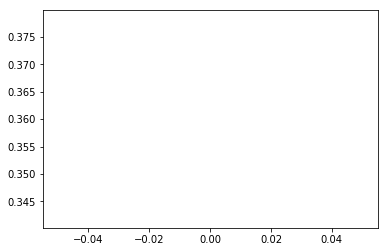

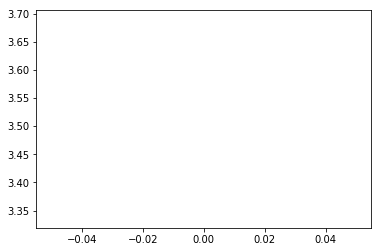

  0%|                                                                            | 24/60000 [00:59<43:20:25,  2.60s/it]

In [ ]:
# 13.7 it/s
config.learning_rate = 0.1
config.store_path = "../../models/CNN/MNIST/withoutBN/"
losses, train_acc, test_acc = train(is_using_BN = False)

0.9965
1.0
0.0172727


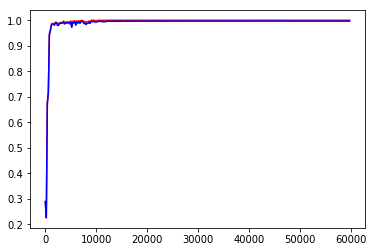

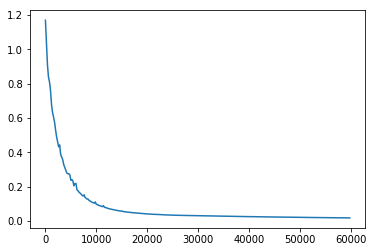

100%|██████████████████████████████████████████████████████| 60000/60000 [2:10:21<00:00,  1.13s/it]


In [8]:
# 8.6
config.learning_rate = 0.1
config.store_path = "../../models/CNN/MNIST/withBN/"
losses, train_acc, test_acc = train(is_using_BN = True)

## TRAIN NETWORKS

## RESTORE MODELS

Restore

In [18]:
#sess = tf.InteractiveSession()
#sess.close()

correct = []
graph = tf.Graph()
with graph.as_default():
    (x_eval, y_eval, is_training), _, accuracy, y_out, loss, saver_eval = build_graph(is_using_BN=True)

with tf.Session(graph = graph) as sess:
    for i in range(0, 2000, 500):
        saver_eval = tf.train.import_meta_graph('../../models/CNN/mnist/withBN/model.ckpt-50000.meta')
        #sess.run(tf.global_variables_initializer())
        saver_eval.restore(sess, "../../models/CNN/mnist/withBN/model.ckpt-50000")

        cor = sess.run([accuracy],
                       feed_dict={x_eval: dataset.x_train[i:i + 500], 
                                  y_eval: dataset.y_train[i:i + 500], 
                                  is_training: False})
        correct.append(cor[0])
        
print (sum(correct) / len(correct))

1.00000011921
